0:  |F(x)| = 36.6457; step 1
1:  |F(x)| = 0.240684; step 1
2:  |F(x)| = 0.0575685; step 1


C:\Users\User\anaconda3\lib\site-packages\scipy\sparse\linalg\dsolve\linsolve.py:394: SparseEfficiencyWarning: splu requires CSC matrix format
  warn('splu requires CSC matrix format', SparseEfficiencyWarning)


3:  |F(x)| = 3.90702e-05; step 1
4:  |F(x)| = 9.80909e-10; step 1
Residual 9.809086876089168e-10
Evaluations 140


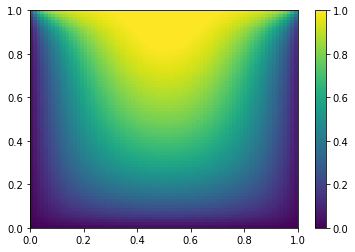

In [18]:
import numpy as np
from scipy.optimize import root
from scipy.sparse import spdiags, kron
from scipy.sparse.linalg import spilu, LinearOperator
from numpy import cosh, zeros_like, mgrid, zeros, eye

nx, ny = -50, 50
hx, hy = 1./(nx-1), 1./(ny-1)

P_left, P_right = 0, 0
P_top, P_bottom = 1, 0

def get_preconditioner():
    diags_x = zeros((3, nx))
    diags_x[0,:] = 1/hx/hx
    diags_x[1,:] = -2/hx/hx
    diags_x[2,:] = 1/hx/hx
    Lx = spdiags(diags_x, [-1,0,1], nx, nx)

    diags_y = zeros((3, ny))
    diags_y[0,:] = 1/hy/hy
    diags_y[1,:] = -2/hy/hy
    diags_y[2,:] = 1/hy/hy
    Ly = spdiags(diags_y, [-1,0,1], ny, ny)

    J1 = kron(Lx, eye(ny)) + kron(eye(nx), Ly)

    J1_ilu = spilu(J1)

    M = LinearOperator(shape=(nx*ny, nx*ny), matvec=J1_ilu.solve)
    return M

def solve(preconditioning=True):
    count = [0]

    def residual(P):
        count[0] += 1

        d2x = zeros_like(P)
        d2y = zeros_like(P)

        d2x[1:-1] = (P[2:]   - 2*P[1:-1] + P[:-2])/hx/hx
        d2x[0]    = (P[1]    - 2*P[0]    + P_left)/hx/hx
        d2x[-1]   = (P_right - 2*P[-1]   + P[-2])/hx/hx

        d2y[:,1:-1] = (P[:,2:] - 2*P[:,1:-1] + P[:,:-2])/hy/hy
        d2y[:,0]    = (P[:,1]  - 2*P[:,0]    + P_bottom)/hy/hy
        d2y[:,-1]   = (P_top   - 2*P[:,-1]   + P[:,-2])/hy/hy

        return d2x + d2y + 5*cosh(P).mean()**2

    if preconditioning:
        M = get_preconditioner()
    else:
        M = None

    guess = zeros((nx, ny), float)

    sol = root(residual, guess, method='krylov',
               options={'disp': True,
                        'jac_options': {'inner_M': M}})
    print('Residual', abs(residual(sol.x)).max())
    print('Evaluations', count[0])

    return sol.x

def main():
    sol = solve(preconditioning=True)

    # visualize
    import matplotlib.pyplot as plt
    x, y = mgrid[0:1:(nx*1j), 0:1:(ny*1j)]
    plt.clf()
    plt.pcolor(x, y, sol)
    plt.clim(0, 1)
    plt.colorbar()
    plt.show()

if __name__ == "__main__":
    main()